In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
(Path.cwd().parent)

PosixPath('/home/ubuntu/varios/skforecast')

In [3]:
################################################################################
#                            ForecasterAutoreg                                 #
#                                                                              #
# This work by Joaquin Amat Rodrigo and Javier Escobar Ortiz is licensed       #
# under a Creative Commons Attribution 4.0 International License.              #
################################################################################
# coding=utf-8

from typing import Union, Dict, List, Tuple, Any, Optional
import warnings
import logging
import sys
import inspect
from inspect import getsource
import numpy as np
import pandas as pd
import sklearn
import sklearn.pipeline
from sklearn.base import clone
from copy import copy

import skforecast
from skforecast.ForecasterBase import ForecasterBase
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import transform_series
from skforecast.utils import transform_dataframe

logging.basicConfig(
    format = '%(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)



In [4]:
class ForecasterAutoreg(ForecasterBase):
    """
    This class turns any regressor compatible with the scikit-learn API into a
    recursive autoregressive (multi-step) forecaster.
    
    Parameters
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API.
        
    lags : int, list, 1d numpy ndarray, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags` (included).
            `list`, `numpy ndarray` or `range`: include only lags present in `lags`,
            all elements must be int.

    transformer_y : transformer (preprocessor) compatible with the scikit-learn
                    preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API with methods: fit, transform, fit_transform and inverse_transform.
        ColumnTransformers are not allowed since they do not have inverse_transform method.
        The transformation is applied to `y` before training the forecaster. 
        **New in version 0.5.0**

    transformer_exog : transformer (preprocessor) compatible with the scikit-learn
                       preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `exog` before training the
        forecaster. `inverse_transform` is not available when using ColumnTransformers.
        **New in version 0.5.0**

    weight_func : callable
        Function that defines the individual weights for each sample based on the
        index. For example, a function that assigns a lower weight to certain dates.
        Ignored if `regressor` does not have the argument `sample_weight` in its `fit`
        method.
        **New in version 0.6.0**
    
    Attributes
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API.
        
    lags : numpy ndarray
        Lags used as predictors.

    transformer_y : transformer (preprocessor) compatible with the scikit-learn
                    preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API with methods: fit, transform, fit_transform and inverse_transform.
        ColumnTransformers are not allowed since they do not have inverse_transform method.
        The transformation is applied to `y` before training the forecaster.
        **New in version 0.5.0**

    transformer_exog : transformer (preprocessor) compatible with the scikit-learn
                    preprocessing API, default `None`
        An instance of a transformer (preprocessor) compatible with the scikit-learn
        preprocessing API. The transformation is applied to `exog` before training the
        forecaster. `inverse_transform` is not available when using ColumnTransformers.
        **New in version 0.5.0**
        
    max_lag : int
        Maximum value of lag included in `lags`.

    last_window : pandas Series
        Last window the forecaster has seen during trained. It stores the
        values needed to predict the next `step` right after the training data.
        
    window_size : int
        Size of the window needed to create the predictors. It is equal to
        `max_lag`.
        
    fitted : Bool
        Tag to identify if the regressor has been fitted (trained).

    weight_func : callable
        Function that defines the individual weights for each sample based on the
        index. For example, a function that assigns a lower weight to certain dates.
        Ignored if `regressor` does not have the argument `sample_weight` in its `fit`
        method.
        **New in version 0.6.0**
        
    source_code_weight_func : str
        Source code of the custom function used to create weights.
        **New in version 0.6.0**
        
    index_type : type
        Type of index of the input used in training.
        
    index_freq : str
        Frequency of Index of the input used in training.
        
    training_range : pandas Index
        First and last values of index of the data used during training.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type of exogenous variable/s used in training.
        
    exog_col_names : list
        Names of columns of `exog` if `exog` used in training was a pandas
        DataFrame.

    X_train_col_names : list
        Names of columns of the matrix created internally for training.
        
    in_sample_residuals : pandas Series
        Residuals of the model when predicting training data. Only stored up to
        1000 values.
        
    out_sample_residuals : pandas Series
        Residuals of the model when predicting non training data. Only stored
        up to 1000 values. Use `set_out_sample_residuals` to set values.

    creation_date : str
        Date of creation.

    fit_date : str
        Date of last fit.

    skforcast_version : str
        Version of skforecast library used to create the forecaster.

    python_version : str
        Version of python used to create the forecaster.
        **New in version 0.5.0**     
    """
    
    def __init__(
        self,
        regressor: object,
        lags: Union[int, np.ndarray, list],
        transformer_y: Optional[object]= None,
        transformer_exog: Optional[object]= None,
        weight_func: callable= None
    ) -> None:
        
        self.regressor               = regressor
        self.transformer_y           = transformer_y
        self.transformer_exog        = transformer_exog
        self.weight_func             = weight_func
        self.source_code_weight_func = None
        self.index_freq              = None
        self.training_range          = None
        self.last_window             = None
        self.included_exog           = False
        self.exog_type               = None
        self.exog_col_names          = None
        self.X_train_col_names       = None
        self.in_sample_residuals     = None
        self.out_sample_residuals    = None
        self.fitted                  = False
        self.creation_date           = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.fit_date                = None
        self.skforcast_version       = skforecast.__version__
        self.python_version          = sys.version.split(" ")[0]
        self.index_type              = None
        
        if isinstance(lags, int) and lags < 1:
            raise ValueError('Minimum value of lags allowed is 1.')

        if isinstance(lags, (list, np.ndarray)):
            for lag in lags:
                if not isinstance(lag, (int, np.int64, np.int32)):
                    raise TypeError('All values in `lags` must be int.')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise ValueError('Minimum value of lags allowed is 1.')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise TypeError(
                '`lags` argument must be int, 1d numpy ndarray, range or list. '
                f"Got {type(lags)}"
            )
        if weight_func is not None:
            self.source_code_weight_func = getsource(weight_func)
            if 'sample_weight' not in inspect.getfullargspec(self.regressor.fit)[0]:
                Warning(
                    f"""
                    Argument `weight_func` is ignored since regressor {self.regressor}
                    does not accept `sample_weight` in its `fit` method.
                    """
                )
                self.weight_func = None
                self.source_code_weight_func = None

        self.max_lag  = max(self.lags)
        self.window_size = self.max_lag


    def __repr__(
        self
    ) -> str:
        """
        Information displayed when a ForecasterAutoreg object is printed.
        """

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            name_pipe_steps = tuple(name + "__" for name in self.regressor.named_steps.keys())
            params = {key : value for key, value in self.regressor.get_params().items() \
                     if key.startswith(name_pipe_steps)}
        else:
            params = self.regressor.get_params()

        info = (
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"{str(type(self)).split('.')[1]} \n"
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"Regressor: {self.regressor} \n"
            f"Lags: {self.lags} \n"
            f"Transformer for y: {self.transformer_y} \n"
            f"Transformer for exog: {self.transformer_exog} \n"
            f"Weights function included: {True if self.weight_func is not None else False} \n"
            f"Window size: {self.window_size} \n"
            f"Included exogenous: {self.included_exog} \n"
            f"Type of exogenous variable: {self.exog_type} \n"
            f"Exogenous variables names: {self.exog_col_names} \n"
            f"Training range: {self.training_range.to_list() if self.fitted else None} \n"
            f"Training index type: {str(self.index_type).split('.')[-1][:-2] if self.fitted else None} \n"
            f"Training index frequency: {self.index_freq if self.fitted else None} \n"
            f"Regressor parameters: {params} \n"
            f"Creation date: {self.creation_date} \n"
            f"Last fit date: {self.fit_date} \n"
            f"Skforecast version: {self.skforcast_version} \n"
            f"Python version: {self.python_version} \n"
        )

        return info

    
    def _create_lags(
        self, 
        y: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """       
        Transforms a 1d array into a 2d array (X) and a 1d array (y). Each row
        in X is associated with a value of y and it represents the lags that
        precede it.
        
        Notice that, the returned matrix X_data, contains the lag 1 in the first
        column, the lag 2 in the second column and so on.
        
        Parameters
        ----------        
        y : 1d numpy ndarray
            Training time series.

        Returns 
        -------
        X_data : 2d numpy ndarray, shape (samples - max(self.lags), len(self.lags))
            2d numpy array with the lagged values (predictors).
        
        y_data : 1d numpy ndarray, shape (samples - max(self.lags),)
            Values of the time series related to each row of `X_data`.
        
        """
          
        n_splits = len(y) - self.max_lag
        if n_splits <= 0:
            raise ValueError(
                f'The maximum lag ({self.max_lag}) must be less than the length '
                f'of the series ({len(y)}).'
            )
        
        X_data = np.full(shape=(n_splits, self.max_lag), fill_value=np.nan, dtype=float)
        y_data = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype=float)

        for i in range(n_splits):
            X_index = np.arange(i, self.max_lag + i)
            y_index = [self.max_lag + i]
            X_data[i, :] = y[X_index]
            y_data[i]    = y[y_index]
            
        X_data = X_data[:, -self.lags] # Only keep needed lags
        y_data = y_data.ravel()
            
        return X_data, y_data


    def create_train_X_y(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Create training matrices from univariate time series and exogenous
        variables.
        
        Parameters
        ----------        
        y : pandas Series
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned.

        Returns 
        -------
        X_train : pandas DataFrame, shape (len(y) - self.max_lag, len(self.lags))
            Pandas DataFrame with the training values (predictors).
            
        y_train : pandas Series, shape (len(y) - self.max_lag, )
            Values (target) of the time series related to each row of `X_train`.
        
        """
        
        check_y(y=y)
        y = transform_series(
                series            = y,
                transformer       = self.transformer_y,
                fit               = True,
                inverse_transform = False
            )
        y_values, y_index = preprocess_y(y=y)
        
        if exog is not None:
            if len(exog) != len(y):
                raise ValueError(
                    f'`exog` must have same number of samples as `y`. '
                    f'length `exog`: ({len(exog)}), length `y`: ({len(y)})'
                )
            check_exog(exog=exog)
            if isinstance(exog, pd.Series):
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = True,
                            inverse_transform = False
                       )
            else:
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = True,
                            inverse_transform = False
                       )
            exog_values, exog_index = preprocess_exog(exog=exog)
            
            if not (exog_index[:len(y_index)] == y_index).all():
                raise ValueError(
                    ('Different index for `y` and `exog`. They must be equal '
                     'to ensure the correct alignment of values.')      
                )
        
        X_train, y_train = self._create_lags(y=y_values)
        X_train_col_names = [f"lag_{i}" for i in self.lags]
        if exog is not None:
            col_names_exog = exog.columns if isinstance(exog, pd.DataFrame) else [exog.name]
            X_train_col_names.extend(col_names_exog)
            # The first `self.max_lag` positions have to be removed from exog
            # since they are not in X_train.
            X_train = np.column_stack((X_train, exog_values[self.max_lag:, ]))

        X_train = pd.DataFrame(
                    data    = X_train,
                    columns = X_train_col_names,
                    index   = y_index[self.max_lag: ]
                  )
        self.X_train_col_names = X_train_col_names
        y_train = pd.Series(
                    data  = y_train,
                    index = y_index[self.max_lag: ],
                    name  = 'y'
                 )
                        
        return X_train, y_train

        
    def fit(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> None:
        """
        Training Forecaster.
        
        Parameters
        ----------        
        y : pandas Series
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned so
            that y[i] is regressed on exog[i].

        Returns 
        -------
        None
        
        """
        
        # Reset values in case the forecaster has already been fitted.
        self.index_type           = None
        self.index_freq           = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.fitted               = False
        self.training_range       = None
        
        if exog is not None:
            self.included_exog = True
            self.exog_type = type(exog)
            self.exog_col_names = \
                 exog.columns.to_list() if isinstance(exog, pd.DataFrame) else exog.name

        X_train, y_train = self.create_train_X_y(y=y, exog=exog)

        if self.weight_func is not None:
            weights = self.weight_func(X_train.index)
            if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
                self.regressor.fit(X=X_train, y=y_train, sample_weight=weights)
            else:
                self.regressor.fit(X=X_train.to_numpy(), y=y_train.to_numpy(), sample_weight=weights)
        else:
            if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
                self.regressor.fit(X=X_train, y=y_train)
            else:
                self.regressor.fit(X=X_train.to_numpy(), y=y_train.to_numpy())

        self.fitted = True
        self.fit_date = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.training_range = preprocess_y(y=y)[1][[0, -1]]
        self.index_type = type(X_train.index)
        if isinstance(X_train.index, pd.DatetimeIndex):
            self.index_freq = X_train.index.freqstr
        else: 
            self.index_freq = X_train.index.step

        if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
            residuals = y_train - self.regressor.predict(X_train)
        else:
            residuals = y_train - self.regressor.predict(X_train.to_numpy())

        residuals = pd.Series(
                        data  = residuals,
                        index = y_train.index,
                        name  = 'in_sample_residuals'
                    )

        if len(residuals) > 1000:
            # Only up to 1000 residuals are stored
            residuals = residuals.sample(n=1000, random_state=123, replace=False)
                                                  
        self.in_sample_residuals = residuals
        
        # The last time window of training data is stored so that lags needed as
        # predictors in the first iteration of `predict()` can be calculated.
        self.last_window = y.iloc[-self.max_lag:].copy()
    

    def _recursive_predict(
        self,
        steps: int,
        last_window: np.ndarray,
        exog: np.ndarray
    ) -> np.ndarray:
        """
        Predict n steps ahead. It is an iterative process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        last_window : numpy ndarray
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
            
        exog : numpy ndarray, pandas DataFrame
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : numpy ndarray
            Predicted values.
        
        """

        predictions = np.full(shape=steps, fill_value=np.nan)

        for i in range(steps):
            X = last_window[-self.lags].reshape(1, -1)
            if exog is not None:
                X = np.column_stack((X, exog[i, ].reshape(1, -1)))

            with warnings.catch_warnings():
                # Suppress scikit-learn warning: "X does not have valid feature names,
                # but NoOpTransformer was fitted with feature names".
                warnings.simplefilter("ignore")
                prediction = self.regressor.predict(X)
                predictions[i] = prediction.ravel()[0]

            # Update `last_window` values. The first position is discarded and 
            # the new prediction is added at the end.
            last_window = np.append(last_window[1:], prediction)

        return predictions

            
    def predict(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> pd.Series:
        """
        Predict n steps ahead. It is an recursive process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        last_window : pandas Series, default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in `self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : pandas Series
            Predicted values.
            
        """

        check_predict_input(
            forecaster_type = type(self),
            steps           = steps,
            fitted          = self.fitted,
            included_exog   = self.included_exog,
            index_type      = self.index_type,
            index_freq      = self.index_freq,
            window_size     = self.window_size,
            last_window     = last_window,
            exog            = exog,
            exog_type       = self.exog_type,
            exog_col_names  = self.exog_col_names,
            interval        = None,
            max_steps       = None,
            level           = None,
            series_levels   = None
        ) 

        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
            else:
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
            
            exog_values, _ = preprocess_exog(
                                exog = exog.iloc[:steps, ]
                             )
        else:
            exog_values = None
            
        if last_window is None:
            last_window = self.last_window.copy()
        
        last_window = transform_series(
                            series            = last_window,
                            transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = False
                      )
        last_window_values, last_window_index = preprocess_last_window(
                                                    last_window = last_window
                                                )
            
        predictions = self._recursive_predict(
                        steps       = steps,
                        last_window = copy(last_window_values),
                        exog        = copy(exog_values)
                      )

        predictions = pd.Series(
                        data  = predictions,
                        index = expand_index(
                                    index = last_window_index,
                                    steps = steps
                                ),
                        name = 'pred'
                      )

        predictions = transform_series(
                        series            = predictions,
                        transformer       = self.transformer_y,
                        fit               = False,
                        inverse_transform = True
                      )

        return predictions
    
    
    def _estimate_boot_interval(
        self,
        steps: int,
        last_window: Optional[np.ndarray]=None,
        exog: Optional[np.ndarray]=None,
        interval: list=[5, 95],
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> np.ndarray:
        """
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. This method only returns prediction intervals.
        See predict_intervals() to calculate both, predictions and intervals.
        
        Parameters
        ----------   
        steps : int
            Number of future steps predicted.
            
        last_window : 1d numpy ndarray shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) needed in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : numpy ndarray, default `None`
            Exogenous variable/s included as predictor/s.
            
        n_boot : int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.

        random_state : int
            Sets a seed to the random generator, so that boot intervals are always 
            deterministic.
            
        interval : list, default `[5, 95]`
            Confidence of the prediction interval estimated. Sequence of 
            percentiles to compute, which must be between 0 and 100 inclusive. 
            For example, interval of 95% should be as `interval = [2.5, 97.5]`.
            
        in_sample_residuals : bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user should have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).
            

        Returns 
        -------
        prediction_interval : numpy ndarray, shape (steps, 2)
            Interval estimated for each prediction by bootstrapping:
            
            - lower_bound: lower bound of the interval.
            - upper_bound: upper bound interval of the interval.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        """
        
        if last_window is None:
            last_window = self.last_window.values

        boot_predictions = np.full(
                                shape      = (steps, n_boot),
                                fill_value = np.nan,
                                dtype      = float
                           )
        rng = np.random.default_rng(seed=random_state)
        seeds = rng.integers(low=0, high=10000, size=n_boot)

        for i in range(n_boot):
            # In each bootstraping iteration the initial last_window and exog 
            # need to be restored.
            last_window_boot = last_window.copy()
            if exog is not None:
                exog_boot = exog.copy()
            else:
                exog_boot = None
 
            if in_sample_residuals:
                residuals = self.in_sample_residuals
            else:
                residuals = self.out_sample_residuals

            rng = np.random.default_rng(seed=seeds[i])
            sample_residuals = rng.choice(
                                    a       = residuals,
                                    size    = steps,
                                    replace = True
                               )

            for step in range(steps):
                prediction = self._recursive_predict(
                                steps       = 1,
                                last_window = last_window_boot,
                                exog        = exog_boot 
                             )
                
                prediction_with_residual  = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual

                last_window_boot = np.append(
                                    last_window_boot[1:],
                                    prediction_with_residual
                                   )
                
                if exog is not None:
                    exog_boot = exog_boot[1:]
                            
        prediction_interval = np.percentile(boot_predictions, q=interval, axis=1)
        prediction_interval = prediction_interval.transpose()
        
        return prediction_interval
    
        
    def predict_interval(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        interval: list=[5, 95],
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> pd.DataFrame:
        """
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. Both, predictions and intervals, are returned.
        
        Parameters
        ---------- 
        steps : int
            Number of future steps predicted.
            
        last_window : pandas Series, default `None`
            Values of the series used to create the predictors (lags) needed in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.
            
        interval : list, default `[5, 95]`
            Confidence of the prediction interval estimated. Sequence of 
            percentiles to compute, which must be between 0 and 100 inclusive. 
            For example, interval of 95% should be as `interval = [2.5, 97.5]`.
            
        n_boot : int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.

        random_state : int, default 123
            Sets a seed to the random generator, so that boot intervals are always 
            deterministic.
            
        in_sample_residuals : bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user should have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).

        Returns 
        -------
        predictions : pandas DataFrame
            Values predicted by the forecaster and their estimated interval:

            - pred: predictions.
            - lower_bound: lower bound of the interval.
            - upper_bound: upper bound interval of the interval.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        """
        
        check_predict_input(
            forecaster_type = type(self),
            steps           = steps,
            fitted          = self.fitted,
            included_exog   = self.included_exog,
            index_type      = self.index_type,
            index_freq      = self.index_freq,
            window_size     = self.window_size,
            last_window     = last_window,
            exog            = exog,
            exog_type       = self.exog_type,
            exog_col_names  = self.exog_col_names,
            interval        = interval,
            max_steps       = None,
            level           = None,
            series_levels   = None
        ) 
        
        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog = transform_dataframe(
                            df                = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
            else:
                exog = transform_series(
                            series            = exog,
                            transformer       = self.transformer_exog,
                            fit               = False,
                            inverse_transform = False
                       )
            
            exog_values, _ = preprocess_exog(
                                exog = exog.iloc[:steps, ]
                             )
        else:
            exog_values = None
        
        if last_window is None:
            last_window = self.last_window.copy()
        
        last_window = transform_series(
                            series            = last_window,
                            transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = False
                      )
        last_window_values, last_window_index = preprocess_last_window(
                                                    last_window = last_window
                                                )

        # Since during predict() `last_window_values` and `exog_values` are modified,
        # the originals are stored to be used later.
        last_window_values_original = last_window_values.copy()
        if exog is not None:
            exog_values_original = exog_values.copy()
        else:
            exog_values_original = None
        
        predictions = self._recursive_predict(
                            steps       = steps,
                            last_window = last_window_values,
                            exog        = exog_values
                      )

        predictions_interval = self._estimate_boot_interval(
                                    steps       = steps,
                                    last_window = copy(last_window_values_original),
                                    exog        = copy(exog_values_original),
                                    interval    = interval,
                                    n_boot      = n_boot,
                                    random_state = random_state,
                                    in_sample_residuals = in_sample_residuals
                               )
        
        predictions = np.column_stack((predictions, predictions_interval))

        predictions = pd.DataFrame(
                        data = predictions,
                        index = expand_index(
                                    index = last_window_index,
                                    steps = steps
                                ),
                        columns = ['pred', 'lower_bound', 'upper_bound']
                      )
                      
        if self.transformer_y:
            for col in predictions.columns:
                predictions[col] = self.transformer_y.inverse_transform(predictions[[col]])

        return predictions

    
    def set_params(
        self, 
        **params: dict
    ) -> None:
        """
        Set new values to the parameters of the scikit learn model stored in the
        ForecasterAutoreg.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        """

        self.regressor = clone(self.regressor)
        self.regressor.set_params(**params)
        
        
    def set_lags(
        self, 
        lags: Union[int, list, np.ndarray, range]
    ) -> None:
        """      
        Set new value to the attribute `lags`.
        Attributes `max_lag` and `window_size` are also updated.
        
        Parameters
        ----------
        lags : int, list, 1D np.array, range
            Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
                `int`: include lags from 1 to `lags`.
                `list` or `np.array`: include only lags present in `lags`.

        Returns 
        -------
        None
        
        """
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        self.window_size = max(self.lags)
        
        
    def set_out_sample_residuals(
        self, 
        residuals: pd.Series, 
        append: bool=True,
        transform: bool=True
    )-> None:
        """
        Set new values to the attribute `out_sample_residuals`. Out of sample
        residuals are meant to be calculated using observations that did not
        participate in the training process.
        
        Parameters
        ----------
        residuals : pd.Series
            Values of residuals. If len(residuals) > 1000, only a random sample
            of 1000 values are stored.
            
        append : bool, default `True`
            If `True`, new residuals are added to the once already stored in the
            attribute `out_sample_residuals`. Once the limit of 1000 values is
            reached, no more values are appended. If False, `out_sample_residuals`
            is overwritten with the new residuals.

        transform : bool, default `True`
            If `True`, new residuals are transformed using self.transformer_y.
            
        Returns 
        -------
        self

        """

        if not isinstance(residuals, pd.Series):
            raise Exception(
                f"`residuals` argument must be `pd.Series`. Got {type(residuals)}"
            )

        if not transform and self.transformer_y is not None:
            warnings.warn(
                f'''
                Argument `transform` is set to `False` but forecaster was trained
                using a transformer {self.transformer_y}. Ensure that new residuals 
                are already transformed or set `transform=True`.
                '''
            )

        if transform and self.transformer_y is not None:
            warnings.warn(
                f'''
                Residuals will be transformed using the same transformer used 
                when training the forecaster ({self.transformer_y}). Ensure that
                new residuals are in the same scale as the original time series.
                '''
            )

            residuals = transform_series(
                            series            = residuals,
                            transformer       = self.transformer_y,
                            fit               = False,
                            inverse_transform = False
                        )
            
        if len(residuals) > 1000:
            rng = np.random.default_rng(seed=123)
            residuals = rng.choice(a=residuals, size=1000, replace=False)
            residuals = pd.Series(residuals)   
    
        if append and self.out_sample_residuals is not None:
            free_space = max(0, 1000 - len(self.out_sample_residuals))
            if len(residuals) < free_space:
                residuals = np.hstack((
                                self.out_sample_residuals,
                                residuals
                            ))
            else:
                residuals = np.hstack((
                                self.out_sample_residuals,
                                residuals[:free_space]
                            ))

        self.out_sample_residuals = pd.Series(residuals)

    
    def get_feature_importance(
        self
    ) -> pd.DataFrame:
        """      
        Return feature importance of the regressor stored in the
        forecaster. Only valid when regressor stores internally the feature
        importance in the attribute `feature_importances_` or `coef_`.

        Parameters
        ----------
        self

        Returns
        -------
        feature_importance : pandas DataFrame
            Feature importance associated with each predictor.

        """

        if self.fitted == False:
            raise sklearn.exceptions.NotFittedError(
                "This forecaster is not fitted yet. Call `fit` with appropriate "
                "arguments before using `get_feature_importance()`."
            )

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            estimator = self.regressor[-1]
        else:
            estimator = self.regressor

        try:
            feature_importance = pd.DataFrame({
                                    'feature': self.X_train_col_names,
                                    'importance' : estimator.feature_importances_
                                })
        except:   
            try:
                feature_importance = pd.DataFrame({
                                        'feature': self.X_train_col_names,
                                        'importance' : estimator.coef_
                                    })
            except:
                warnings.warn(
                    f"Impossible to access feature importance for regressor of type {type(estimator)}. "
                    f"This method is only valid when the regressor stores internally "
                    f"the feature importance in the attribute `feature_importances_` "
                    f"or `coef_`."
                )

                feature_importance = None

        return feature_importance

In [5]:
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.model_selection import backtesting_forecaster

In [6]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')
data.info()

# Data preprocessing
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right').mean()

# Data alteration
# ==============================================================================
rng = np.random.default_rng(seed=123)
data.loc["2012-06": "2012-09", "Demand"] = rng.normal(
                                              loc   = 3000,
                                              scale = 100,
                                              size  = len(data.loc["2012-06": "2012-09"])
                                          )

# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-10-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB
Dates train      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Dates validacion : 2014-01-01 00:00:00 --- 2014-10-31 00:00:00  (n=304)
Dates test       : 2014-11-01 00:00:00 --- 2014-12-30 00:00:00  (n=60)


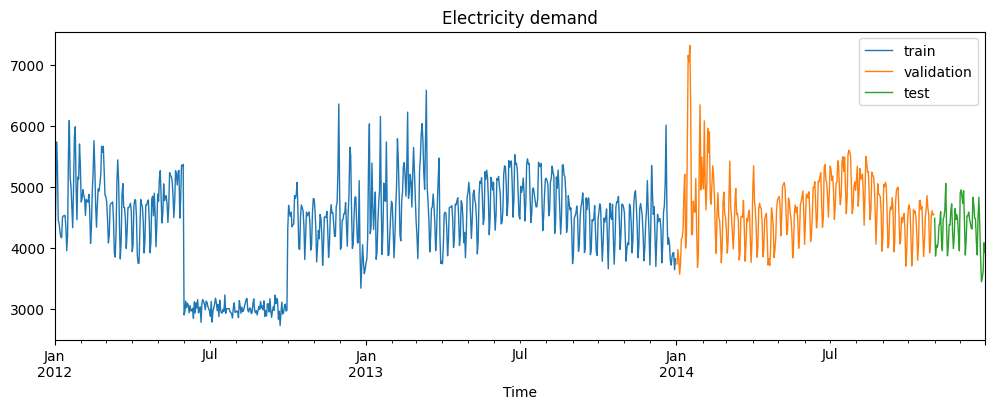

In [7]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.Demand.plot(ax=ax, label='train', linewidth=1)
data_val.Demand.plot(ax=ax, label='validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand')
ax.legend();

In [8]:
# Create Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor    = HistGradientBoostingRegressor(random_state=123),
                 lags         = 21
             )



# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.Demand,
                                   initial_train_size = len(data.loc[:end_train]),
                                   fixed_train_size   = False,
                                   steps              = 10,
                                   metric             = 'mean_absolute_error',
                                   refit              = False,
                                   verbose            = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 305.9148065030094


In [9]:
# Custom function to define weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is one of '2012-06', '2012-07', '2012-08', '2012-09', '2012-10'
    and return 1 otherwise.
    """
    dates = ['2012-06', '2012-07', '2012-08', '2012-09', '2012-10']
    weights = np.where(
                index.strftime('%Y-%m').isin(dates),
                0,
                1

              )
    return weights
    

# Create Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor    = HistGradientBoostingRegressor(random_state=123),
                 lags         = 21,
                 weight_func = custom_weights
             )



# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.Demand,
                                   initial_train_size = len(data.loc[:end_train]),
                                   fixed_train_size   = False,
                                   steps              = 10,
                                   metric             = 'mean_absolute_error',
                                   refit              = False,
                                   verbose            = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 269.82863040469175


In [10]:
forecaster

ForecasterAutoreg'> 
Regressor: HistGradientBoostingRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 
Transformer for y: None 
Transformer for exog: None 
Weights function included: True 
Window size: 21 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'categorical_features': None, 'early_stopping': 'auto', 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'random_state': 123, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-19 15:27:42 
Last fit date: None 
Skforecast version: 0.5.1 
Python version: 3.8.13 